In [0]:
import matplotlib
import matplotlib.pyplot as plt

## Знакомство с тензорами и автоматическое дифференцирование

In [0]:
import torch

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
torch.manual_seed(42)

x = torch.rand(3, 2)
print(x)
print(x.shape)
print()

y = torch.rand(3, 2)
x = x + y
print(x)

tensor([[0.8823, 0.9150],
        [0.3829, 0.9593],
        [0.3904, 0.6009]])
torch.Size([3, 2])

tensor([[1.1388, 1.7086],
        [1.3236, 1.0925],
        [1.3250, 1.1945]])


In [5]:
import numpy as np

x = np.ones((3, 2), dtype=np.float32)
z = torch.from_numpy(x)

print(x)
print(z)

[[1. 1.]
 [1. 1.]
 [1. 1.]]
tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])


In [6]:
x = torch.ones(3,2)
z = x.numpy()

print(x)
print(z)

tensor([[1., 1.],
        [1., 1.],
        [1., 1.]])
[[1. 1.]
 [1. 1.]
 [1. 1.]]


$$F({\bf x})=\left|\left|{\bf x}\right|\right|^2$$
$$\frac{\partial F}{\partial x_i} = ?$$

In [7]:
torch.manual_seed(42)

x = torch.rand(10, requires_grad=True)
print(x)
print()

norm = torch.dot(x, x)
print(norm)
print()

norm.backward()
print(x.grad)

tensor([0.8823, 0.9150, 0.3829, 0.9593, 0.3904, 0.6009, 0.2566, 0.7936, 0.9408,
        0.1332], requires_grad=True)

tensor(4.7945, grad_fn=<DotBackward>)

tensor([1.7645, 1.8300, 0.7657, 1.9186, 0.7809, 1.2018, 0.5131, 1.5873, 1.8815,
        0.2664])


## Классификаторы. Сети прямого распространения

In [0]:
import numpy as np
import pandas as pd

names = ["length", "width", "size", "conc", "conc1", "asym", "m3long", "m3trans", "alpha", "dist", "class"]
data = pd.read_csv('/content/drive/My Drive/2020-hw3-propellermint/magic04.csv', names=names)

x = np.asarray(data.iloc[:, :-1])
y = np.asarray(data.iloc[:, [-1]])
y = (y == 'g').astype(np.float32)

In [0]:
import torch.utils.data

X = torch.from_numpy(x.astype(np.float32))
Y = torch.from_numpy(y.astype(np.float32))

dataset = torch.utils.data.TensorDataset(X, Y)
dataset_len = len(dataset)
train_dataset_len = int(0.8*dataset_len)
test_dataset_len = dataset_len - train_dataset_len

train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_dataset_len, test_dataset_len])
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader  = torch.utils.data.DataLoader(test_dataset,  batch_size=5)

In [12]:
from tqdm.notebook import tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F

torch.manual_seed(42)

INPUT_DIM  = x.shape[1]
HIDDEN_DIM = 20
OUTPUT_DIM = y.shape[1]

model = torch.nn.Sequential(
    torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
    torch.nn.Sigmoid(),
    torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
    torch.nn.Sigmoid(),
)

loss_fn = torch.nn.MSELoss(reduction='sum')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 25
train_loss_hist = []
test_loss_hist = []
for e in tqdm(range(epochs)):
    for i, batch in enumerate(train_loader):
        features, labels = batch
        y_pred = model(features)
        loss = loss_fn(y_pred, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    train_loss_hist.append(loss)
    with torch.no_grad():
        count = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            count += 1
            total_loss += loss
        test_loss_hist.append(total_loss/count)

In [0]:
test_loss_hist2 = test_loss_hist

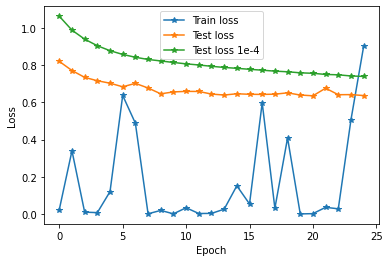

In [13]:
train_loss_hist = np.asarray(train_loss_hist)
test_loss_hist = np.asarray(test_loss_hist)
plt.plot(train_loss_hist, '-*', label='Train loss')
plt.plot(test_loss_hist, '-*', label='Test loss')
plt.plot(test_loss_hist2, '-*', label='Test loss 1e-4')
plt.legend()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [14]:
confusion_matrix = torch.zeros((2,2))
true_and_scores = []
with torch.no_grad():
    for batch in test_loader:
        features, labels = batch
        
        scores = model(features)
        y_pred = (scores > 0.5)
        for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

        true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))
        
true_and_scores = np.vstack(true_and_scores)

tn, fp, fn, tp = confusion_matrix.view(-1)
accuracy  = (tp + tn) / (tn + fp + fn + tp)
precision = tp / (tp + fp)
recall    = tp / (tp + fn)
specificity = tn / (tn + fp)
baccuracy = 0.5 * (specificity + recall)
    
print("Accuracy                  = {:.4f}".format(accuracy))
print("Ballanced accuracy        = {:.4f}".format(baccuracy))
print("Precision (PPV)           = {:.4f}".format(precision))
print("Recall (sensitivity, TPR) = {:.4f}".format(recall))

Accuracy                  = 0.8210
Ballanced accuracy        = 0.7804
Precision (PPV)           = 0.8262
Recall (sensitivity, TPR) = 0.9169


AUC                       = 0.8771


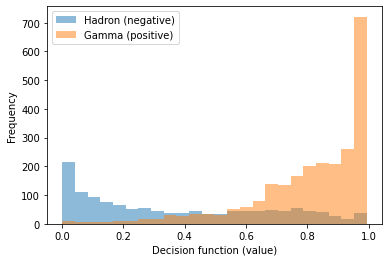

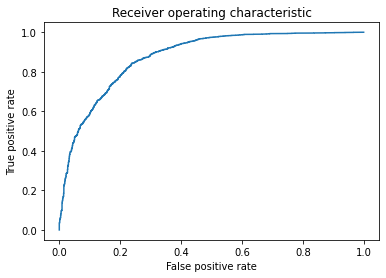

In [15]:
import sklearn.metrics

y_true = true_and_scores[:,0]
scores = true_and_scores[:,1]

min_score, max_score = np.min(scores), np.max(scores)
bins = np.linspace(min_score, max_score, 25)
plt.figure()
plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
plt.xlabel("Decision function (value)")
plt.ylabel("Frequency")
plt.legend()

fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
auc = sklearn.metrics.roc_auc_score(y_true, scores)
plt.figure()
plt.plot(fpr, tpr)
plt.title("Receiver operating characteristic")
plt.xlabel("False positive rate")
plt.ylabel("True positive rate")
print("AUC                       = {:.4f}".format(auc))

**Задание 3a.1** Это задание на *бонусные балы*. Вам нужно использовать готовый код классификатора выше, чтобы улучшить качество классификатора в смысле *AUC*.

Попробуйте исследовать как результат меняется в зависимости от числа скрытых нейронов, вида функции активации, применяемого для обучения оптимизатора. Помогает ли добавление дополнительного скрытого слоя? Поможет ли применение анализа главных компонент для входных данных перед обучением нейросети?

*Бонусные баллы* положены за лучшие пять решений среди всей группы.

In [0]:
def find_better_auc_sigmoid(HIDDEN_DIM, learning_rate):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    #HIDDEN_DIM = 20
    OUTPUT_DIM = y.shape[1]

    model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Sigmoid(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Sigmoid(),
    )

    loss_fn = torch.nn.MSELoss(reduction='sum')

    #learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)


    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show() 


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))




    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))


def find_better_auc_relu(HIDDEN_DIM, learning_rate):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    #HIDDEN_DIM = 20
    OUTPUT_DIM = y.shape[1]

    model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.ReLU(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.ReLU(),
    )

    loss_fn = torch.nn.MSELoss(reduction='sum')

    #learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)


    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show() 


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))




    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))


def find_better_auc_tanh(HIDDEN_DIM, learning_rate):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    #HIDDEN_DIM = 20
    OUTPUT_DIM = y.shape[1]

    model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.Tanh(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.Tanh(),
    )

    loss_fn = torch.nn.MSELoss(reduction='sum')

    #learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)


    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show() 


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))




    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))


def find_better_auc_lru(HIDDEN_DIM, learning_rate):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    #HIDDEN_DIM = 20
    OUTPUT_DIM = y.shape[1]

    model = torch.nn.Sequential(
      torch.nn.Linear(INPUT_DIM, HIDDEN_DIM),
      torch.nn.LeakyReLU(),
      torch.nn.Linear(HIDDEN_DIM, OUTPUT_DIM),
      torch.nn.LeakyReLU(),
    )

    loss_fn = torch.nn.MSELoss(reduction='sum')

    #learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)


    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show() 


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))




    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))


def find_better_auc_elu(HIDDEN_DIM1, HIDDEN_DIM2, HIDDEN_DIM3, learning_rate):
    torch.manual_seed(42)

    INPUT_DIM  = x.shape[1]
    #HIDDEN_DIM = 20
    OUTPUT_DIM = y.shape[1]

    model = torch.nn.Sequential(
        torch.nn.Linear(INPUT_DIM, HIDDEN_DIM1),
        torch.nn.ELU(),
        torch.nn.Linear(HIDDEN_DIM1, HIDDEN_DIM2),
        torch.nn.ELU(),
        torch.nn.Linear(HIDDEN_DIM2, HIDDEN_DIM3),
        torch.nn.ELU(),
        torch.nn.Linear(HIDDEN_DIM3, OUTPUT_DIM),
        torch.nn.ELU(),
      )

    loss_fn = torch.nn.MSELoss(reduction='sum')

    #learning_rate = 1e-3
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    epochs = 25
    train_loss_hist = []
    test_loss_hist = []
    for e in tqdm(range(epochs)):
        for i, batch in enumerate(train_loader):
            features, labels = batch
            y_pred = model(features)
            loss = loss_fn(y_pred, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_loss_hist.append(loss)
        with torch.no_grad():
            count = 0
            total_loss = 0
            for i, batch in enumerate(test_loader):
                features, labels = batch
                y_pred = model(features)
                loss = loss_fn(y_pred, labels)
                count += 1
                total_loss += loss
            test_loss_hist.append(total_loss/count)


    train_loss_hist = np.asarray(train_loss_hist)
    test_loss_hist = np.asarray(test_loss_hist)
    plt.plot(train_loss_hist, '-*', label='Train loss')
    plt.plot(test_loss_hist, '-*', label='Test loss')
    plt.legend()
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.show() 


    confusion_matrix = torch.zeros((2,2))
    true_and_scores = []
    with torch.no_grad():
        for batch in test_loader:
            features, labels = batch

            scores = model(features)
            y_pred = (scores > 0.5)
            for t, p in zip(labels.view(-1), y_pred.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

            true_and_scores.append(np.hstack([labels.numpy(), scores.numpy()]))

    true_and_scores = np.vstack(true_and_scores)

    tn, fp, fn, tp = confusion_matrix.view(-1)
    accuracy  = (tp + tn) / (tn + fp + fn + tp)
    precision = tp / (tp + fp)
    recall    = tp / (tp + fn)
    specificity = tn / (tn + fp)
    baccuracy = 0.5 * (specificity + recall)

    print("Accuracy                  = {:.4f}".format(accuracy))
    print("Ballanced accuracy        = {:.4f}".format(baccuracy))
    print("Precision (PPV)           = {:.4f}".format(precision))
    print("Recall (sensitivity, TPR) = {:.4f}".format(recall))




    y_true = true_and_scores[:,0]
    scores = true_and_scores[:,1]

    min_score, max_score = np.min(scores), np.max(scores)
    bins = np.linspace(min_score, max_score, 25)
    plt.figure()
    plt.hist(scores[y_true.reshape(-1) == 0], bins, alpha=0.5, label='Hadron (negative)')
    plt.hist(scores[y_true.reshape(-1) == 1], bins, alpha=0.5, label='Gamma (positive)')
    plt.xlabel("Decision function (value)")
    plt.ylabel("Frequency")
    plt.legend()

    fpr, tpr, _ = sklearn.metrics.roc_curve(y_true, scores)
    auc = sklearn.metrics.roc_auc_score(y_true, scores)
    plt.figure()
    plt.plot(fpr, tpr)
    plt.title("Receiver operating characteristic")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    print("AUC                       = {:.4f}".format(auc))

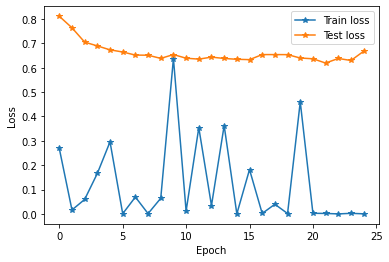

Accuracy                  = 0.8147
Ballanced accuracy        = 0.7596
Precision (PPV)           = 0.8038
Recall (sensitivity, TPR) = 0.9449
AUC                       = 0.8765


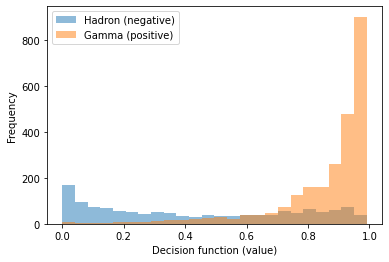

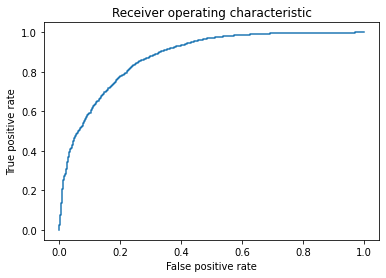

In [17]:
#  sigmoid: hidden_dim = 30, learning_rate = 1e-3
find_better_auc_sigmoid(30, 1e-3)

При увеличении количества скрытых нейронов до 50 удалось повысить AUC c 0.8771 до 0.8867

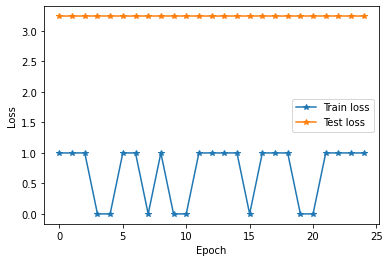

Accuracy                  = 0.3515
Ballanced accuracy        = 0.5000
Precision (PPV)           = nan
Recall (sensitivity, TPR) = 0.0000
AUC                       = 0.5000


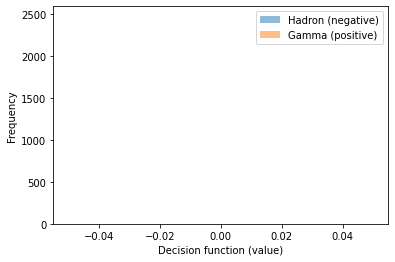

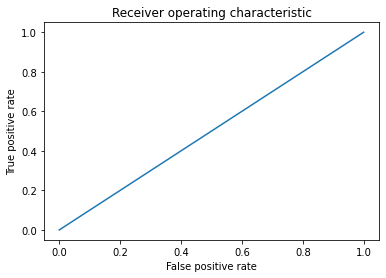

In [18]:
#  ReLu: hidden_dim = 30, learning_rate = 1e-3
find_better_auc_relu(30, 1e-3)

ReLu не годится

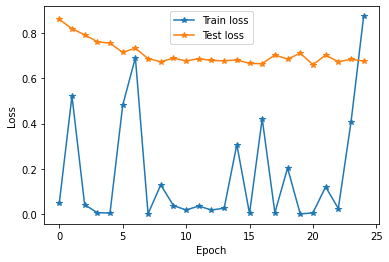

Accuracy                  = 0.8128
Ballanced accuracy        = 0.7666
Precision (PPV)           = 0.8140
Recall (sensitivity, TPR) = 0.9222
AUC                       = 0.8624


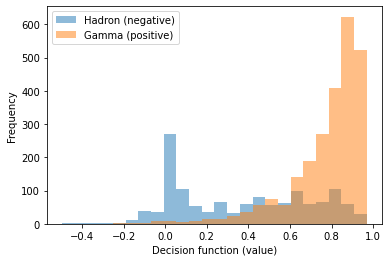

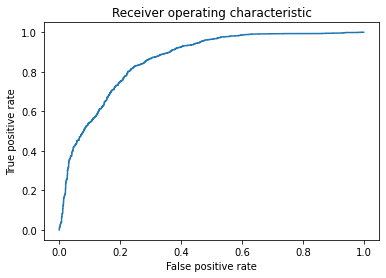

In [19]:
#  Tanh: hidden_dim = 20, learning_rate = 1e-3
find_better_auc_tanh(20, 1e-3)

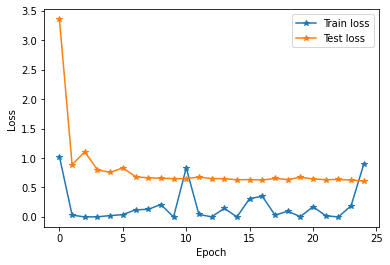

Accuracy                  = 0.8378
Ballanced accuracy        = 0.7972
Precision (PPV)           = 0.8354
Recall (sensitivity, TPR) = 0.9339
AUC                       = 0.8879


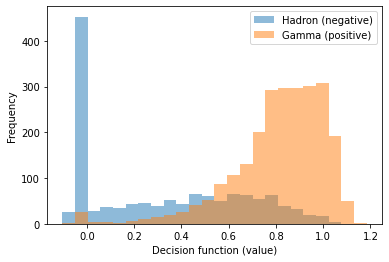

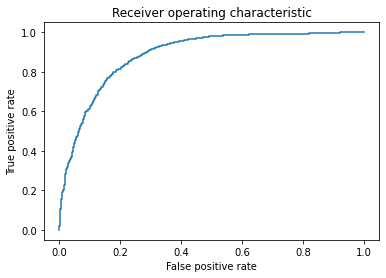

In [20]:
#  LeakyReLu: hidden_dim = 50, learning_rate = 1e-3
find_better_auc_lru(50, 1e-3)

Сигмоида лучше. При меньшем количестве скрытых нейронов и скорости обучения дает лучшее значение AUC. LeakyReLu тоже годится при 50 скрытых нейронах и скорости обучения 1e-3 выдала AUC = 0.8879

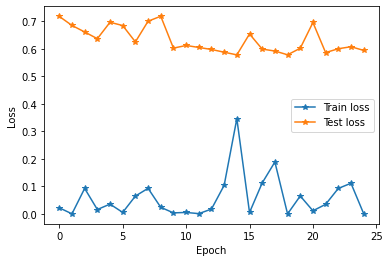

Accuracy                  = 0.8399
Ballanced accuracy        = 0.7909
Precision (PPV)           = 0.8251
Recall (sensitivity, TPR) = 0.9558
AUC                       = 0.9045


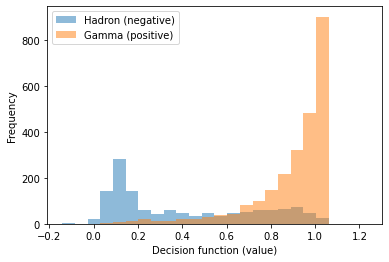

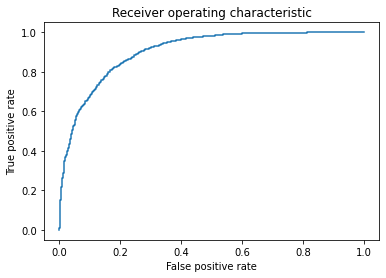

In [21]:
#  ELu: hidden_layers = 80, 60, learning_rate = 1e-3
find_better_auc_elu(80, 70, 60, 1e-3)

#Победил ELu с 2 доп. слоями AUC = 0.9045

**Задание 3a.2** Перед вами набор данных рукописных цифр MNIST (черно-белые изображения, размером 28x28 пикселей каждое). Задача состоит в том, чтобы сделать автоэнкодер на базе свёрточной нейронной сети. Размерность пространства закодированного представления (латентный слой) должна быть 8. Подберите параметры свёрточных слоев.

*Бонусные баллы* положены за автоэнкодер с наименьшим среднеквадратичным отклонением `torch.nn.MSELoss` на тестовых данных и размерностью закодированного представления 8. Попробуйте добавить новые свёрточные слои или менять конфигурацию существующих, или вид функций активации.

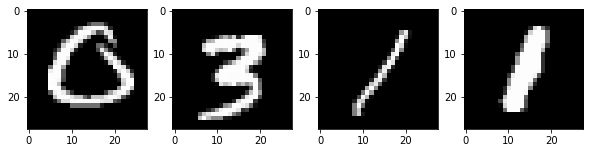

In [22]:
import torchvision
import torchvision.transforms as transforms

torch.manual_seed(43)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.0, 1.0)
])

train_dataset = torchvision.datasets.MNIST(root="./mnist", download=True, transform=transform, train=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = torchvision.datasets.MNIST(root="./mnist", download=True, transform=transform, train=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)
dataiter = iter(train_loader)
images, labels = dataiter.next()

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    plt.imshow(images[i].reshape(28,28), cmap='gray')

plt.show()

In [23]:
torch.manual_seed(43)

INPUT_CH  = images.shape[1]
HIDDEN1_CH = 64 # ???
HIDDEN2_CH = 128 # ???
HIDDEN3_CH = 64
LATENT_DIM = 8

class CNNAutoEncoder(torch.nn.Module):
    def __init__(self):
        super(CNNAutoEncoder, self).__init__()

        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(INPUT_CH, HIDDEN1_CH, 2, stride=2),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(HIDDEN1_CH, HIDDEN2_CH, 2, stride=2, bias=False),
            torch.nn.ReLU(True),

            torch.nn.Conv2d(HIDDEN2_CH, HIDDEN3_CH, 2, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.Conv2d(HIDDEN3_CH, LATENT_DIM, 3, bias=False),
            torch.nn.Sigmoid(),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.LayerNorm((LATENT_DIM, 1, 1)),
            
            torch.nn.ConvTranspose2d(LATENT_DIM, HIDDEN2_CH, 6, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN2_CH, HIDDEN2_CH, 3, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN2_CH, HIDDEN1_CH, 4, stride=2, bias=False),
            torch.nn.ReLU(True),
            
            torch.nn.ConvTranspose2d(HIDDEN1_CH, INPUT_CH, 1, bias=False),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

model = CNNAutoEncoder()

loss_fn = torch.nn.MSELoss(reduction='mean')

learning_rate = 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

epochs = 5
train_loss_hist = []
test_loss_hist = []
for e in range(epochs):
    for i, batch in tqdm(enumerate(train_loader)):
        images, labels = batch
        _, decoded = model(images)
        loss = loss_fn(decoded, images)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
            
    train_loss_hist.append(loss)
    with torch.no_grad():
        count = 0
        total_loss = 0
        for i, batch in enumerate(test_loader):
            images, labels = batch
            _, decoded = model(images)
            loss = loss_fn(decoded, images)
            count += 1
            total_loss += loss
        test_loss_hist.append(total_loss/count)

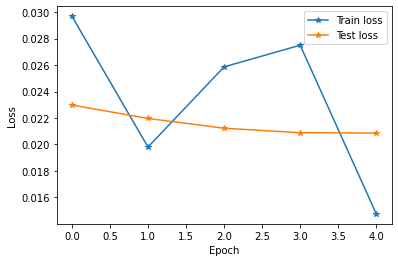

In [24]:
train_loss_hist = np.asarray(train_loss_hist)
test_loss_hist = np.asarray(test_loss_hist)
plt.plot(train_loss_hist, '-*', label='Train loss')
plt.plot(test_loss_hist, '-*', label='Test loss')
plt.legend()
plt.ylabel("Loss") 
plt.xlabel("Epoch")
plt.show()

In [25]:
count = 0
total_loss = 0
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images, labels = batch
        _, decoded = model(images)
        loss = loss_fn(decoded, images)
        
        count += 1
        total_loss += loss

    print("Average loss = {:.4f}".format(total_loss/count))

Average loss = 0.0209


**Задание 3a.3** Используя обученную модель автоэнкодера нарисуйте для четырех изображений тестового набора данных: само изображение, его закодированное представление в виде гистограммы, а так же раскодированное изображение. Ниже приведена заготовка кода рисующего изображения.

torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])


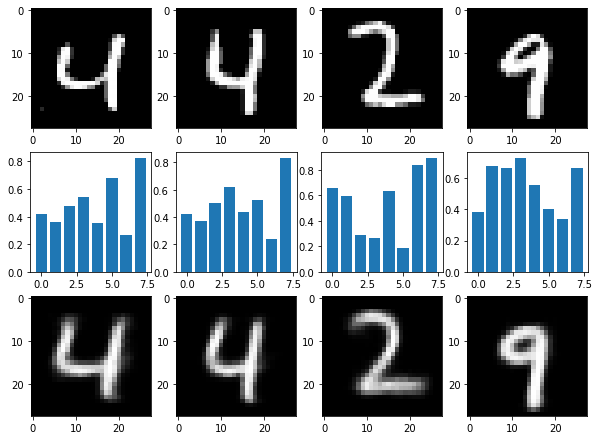

In [26]:
images, _ = iter(test_loader).next()

plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    inp = images # ???
    plt.imshow(inp[i].reshape(28,28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    encoded, decoded = model(images) # ???
    print(encoded.shape)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].detach())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].detach().numpy().reshape(28,28), cmap='gray')

plt.show()

**Задание 3a.4** Проделайте задание **3a.3**, но теперь на вход автоэнкодера следует подать изображения с добавленным к ним равномерно распределенным шумом амплитуды `noise_level`. После добавления шума, входные данные возможно придётся перенормировать, так как нейросеть ожидает, что в каждом пикселе содержится число от $0.0$ до $1.0$. Придумайте как это сделать.

torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])
torch.Size([4, 8, 1, 1])


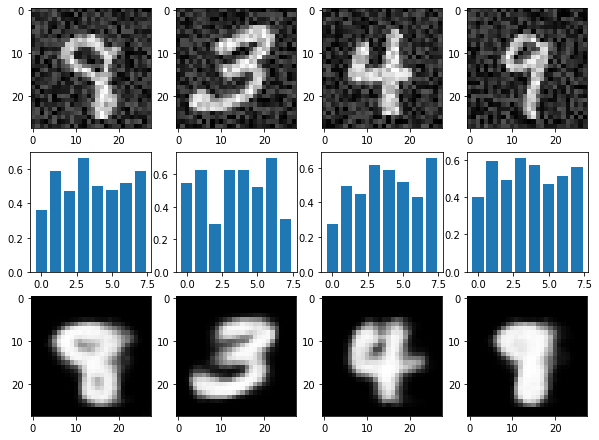

In [27]:
images, _ = iter(test_loader).next()
noise_level = 0.5 #уровень шума
images = (images + torch.rand(4, 1, 28, 28) * noise_level) / (1 + noise_level) # ??? важно следить, чтобы распределения входных данных соответствовали друг другу



plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    inp = images
    plt.imshow(inp[i].reshape(28,28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    encoded, decoded = model(images) # ???
    print(encoded.shape)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].detach())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].detach().numpy().reshape(28,28), cmap='gray')

plt.show()

**Задание 3a.5** В задании **3a.4** вы должны были обнаружить, что автоэнкодер можно использовать для удаления шума из данных. В векторе `noise_levels` задана сетка амплитуды шумов для входных данных. Предлагается построить график зависимости от амплитуды шума для среднеквадратичного отклонения `torch.nn.MSELoss` между выходом автоэнкодера и незашумленным (истинным) входным изображением. Используйте полный тестовый датасет для вычисления значений. При шуме нулевой амплитуды (нет шума) среднеквадратичное отклонение будет определяться самой моделью. При постепенном добавлении шума он будет мешать нейросети распознать исходное изображение абсолютно корректно.

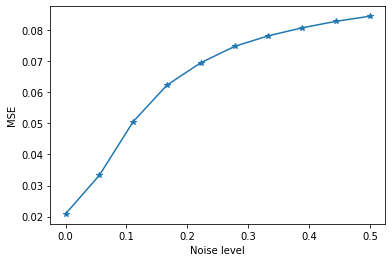

In [28]:
noise_levels = np.linspace(0.0, 0.5, 10)
noise = []

for noise_level in noise_levels:
    count = 0
    total_loss = 0
    with torch.no_grad():
        for i, batch in enumerate(test_loader):
            images, labels = batch
            noised = (images + torch.randn(images.shape) * noise_level) / (1.0 + noise_level)
            _, decoded = model(noised)
            loss = loss_fn(decoded, images)
        
            count += 1
            total_loss += loss
        noise.append([total_loss/count])
        
plt.plot(noise_levels, np.asarray(noise), "-*")
plt.ylabel("MSE")
plt.xlabel("Noise level")
plt.show()

**Задание 3a.6** Аналогично заданию **3a.3** сгенерируйте и подайте на вход декодера случайные данные, совпадающие по своим статистическим свойствам с содержимым латентного слоя. Нарисуйте сгенерированные декодером изображения.

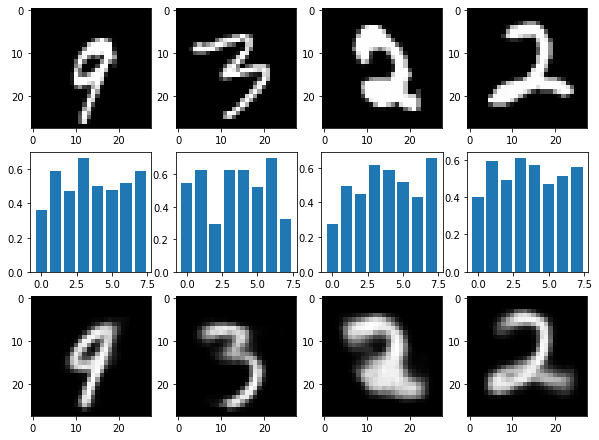

In [29]:
plt.figure(figsize=(10, 7.5))
n_col = 4
for i in range(n_col):
    ax = plt.subplot(3, n_col, i + 1)
    inp = images
    plt.imshow(inp[i].reshape(28, 28), cmap='gray')
    ax = plt.subplot(3, n_col, i + 1 + n_col)
    ecnoded, decoded = model(images)
    plt.bar(np.arange(encoded[i].shape[0]), encoded[i].detach())
    ax = plt.subplot(3, n_col, i + 1 + n_col * 2)
    plt.imshow(decoded[i].detach().numpy().reshape(28, 28), cmap='gray')
plt.show()

**Задание 3a.7** Перед вами набор данных изображений STL10. Он состоит из цветных фотографий размером 96x96, отнесённых к одному из десяти различных классов: аэроплан, птичка, автомобиль, котик, олень, собака, лошадь, обезьяна, корабль, грузовик. Задача состоит в том, чтобы построить классификатор используя свёрточные нейронные сети, используя "transfer learning". Библиотека `torchvision` содержит в себе уже обученную глубокую свёрточную нейросеть AlexNet (`torchvision.models.alexnet`), эта сеть позволяет классифицировать фотографии на 1000 различных классов (набор данных ImageNet) и состоит из двух частей:
 * нескольких свёрточных слоев в начале сети
 * нескольких полносвязных слоев в конце сети
 
Можно считать, что первая половина сети генерирует некоторый набор универсальных признаков, на основе которого можно классифицировать фотографии из других наборов данных. Вам предлагается заменить часть нейросети состоящей из полносвязных слоев для решения задачи классификации STL10. Свёрточные слои обучать не следует, т.е. их веса остаются фиксированными и известными.

В качестве функции потерь для классификатора убодно использовать `torch.nn.CrossEntropyLoss`.

Используйте готовую функцию `sklearn.metrics.confusion_matrix` и класс `sklearn.metrics.ConfusionMatrixDisplay` чтобы вычислить и нарисовать матрицу ошибок для тестового набора данных. Используйте готовую функцию `sklearn.metrics.classification_report`, чтобы подсчитать точность (precision) и полноту (recall) для каждого из целевых классов.

*Бонусные балы* полагаются за лучшее среди всей группы значение функции потерь на тестовом наборе данных.

Files already downloaded and verified
Files already downloaded and verified
['deer' 'monkey' 'ship' 'truck']


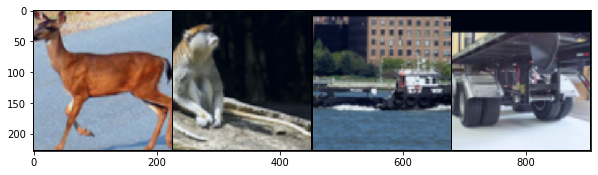

In [30]:
import torch
import torchvision.models
import torchvision.datasets
import torchvision.transforms

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,8))
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    plt.show()

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

train_dataset = torchvision.datasets.STL10("./stl10", split='train', transform=transform, download=True)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=4, shuffle=True)

test_dataset = torchvision.datasets.STL10("./stl10", split='test', transform=transform, download=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=True)

class_names = np.array(["airplane", "bird", "car", "cat", "deer", "dog", "horse", "monkey", "ship", "truck"])

dataiter = iter(train_loader)
images, labels = dataiter.next()

print(class_names[labels.numpy()])
show(torchvision.utils.make_grid(images, normalize=True))

In [0]:
import torchvision.models

alexnet = torchvision.models.alexnet(pretrained=True)
for param in alexnet.parameters():
    param.requires_grad = False

In [32]:
print(alexnet)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

In [33]:
torch.manual_seed(43)

HIDDEN_DIM = 512 # нейроны во внутреннем слое

class ClassifierModel(torch.nn.Module):
    def __init__(self):
        super(ClassifierModel, self).__init__()
        
        self.features = alexnet.features
        self.avgpool = alexnet.avgpool
        self.classifier = torch.nn.Sequential(
            nn.Dropout(),
            # тут должна была быть полносвязная сеть, но она пропала.
            # известно, что на входе должно быть 256 * 6 * 6 значений,
            # а на выходе вектор из 10 признаков
            # хочу построить новую сеть, фичи скопировали из готовой сети,
            # а классифаер свой, чтобы он подходил к предыдущей сети
    torch.nn.Linear(256 * 6 * 6, HIDDEN_DIM),
    torch.nn.Sigmoid(),
    torch.nn.Linear(HIDDEN_DIM, 10),
    torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x
    
model = ClassifierModel()

loss_fn = torch.nn.CrossEntropyLoss()

learning_rate = 1e-3
momentum = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

epochs = 5
for e in range(epochs):
    for i, batch in tqdm(enumerate(train_loader)):
        images, labels = batch
        output = model(images)
        loss = loss_fn(output, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if i % 100 == 0:
            print("epoch = {} batch = {} loss = {}".format(e, i, loss))

epoch = 0 batch = 0 loss = 2.2362146377563477
epoch = 0 batch = 100 loss = 2.207078456878662
epoch = 0 batch = 200 loss = 2.0739078521728516
epoch = 0 batch = 300 loss = 2.1621408462524414
epoch = 0 batch = 400 loss = 2.1311306953430176
epoch = 0 batch = 500 loss = 1.9320158958435059
epoch = 0 batch = 600 loss = 1.9359805583953857
epoch = 0 batch = 700 loss = 1.8681992292404175
epoch = 0 batch = 800 loss = 1.9329301118850708
epoch = 0 batch = 900 loss = 1.9582172632217407
epoch = 0 batch = 1000 loss = 1.8884613513946533
epoch = 0 batch = 1100 loss = 1.8027775287628174
epoch = 0 batch = 1200 loss = 1.8216818571090698



epoch = 1 batch = 0 loss = 1.7367790937423706
epoch = 1 batch = 100 loss = 1.838533639907837
epoch = 1 batch = 200 loss = 1.9576364755630493
epoch = 1 batch = 300 loss = 1.8050580024719238
epoch = 1 batch = 400 loss = 1.8154094219207764
epoch = 1 batch = 500 loss = 1.7516790628433228
epoch = 1 batch = 600 loss = 1.7765276432037354
epoch = 1 batch = 700 loss = 1.6601667404174805
epoch = 1 batch = 800 loss = 1.8796719312667847
epoch = 1 batch = 900 loss = 1.672224521636963
epoch = 1 batch = 1000 loss = 1.7739765644073486
epoch = 1 batch = 1100 loss = 1.6459896564483643
epoch = 1 batch = 1200 loss = 1.775351881980896



epoch = 2 batch = 0 loss = 1.7841848134994507
epoch = 2 batch = 100 loss = 1.6434431076049805
epoch = 2 batch = 200 loss = 1.8434484004974365
epoch = 2 batch = 300 loss = 1.7173001766204834
epoch = 2 batch = 400 loss = 1.6002197265625
epoch = 2 batch = 500 loss = 1.8087724447250366
epoch = 2 batch = 600 loss = 1.6301153898239136
epoch = 2 batch = 700 loss = 1.6486144065856934
epoch = 2 batch = 800 loss = 1.5981614589691162
epoch = 2 batch = 900 loss = 1.5870530605316162
epoch = 2 batch = 1000 loss = 1.5930873155593872
epoch = 2 batch = 1100 loss = 1.6044057607650757
epoch = 2 batch = 1200 loss = 1.542939305305481



epoch = 3 batch = 0 loss = 1.7356674671173096
epoch = 3 batch = 100 loss = 1.7273099422454834
epoch = 3 batch = 200 loss = 1.6466476917266846
epoch = 3 batch = 300 loss = 1.665097951889038
epoch = 3 batch = 400 loss = 1.594398021697998
epoch = 3 batch = 500 loss = 1.627110481262207
epoch = 3 batch = 600 loss = 1.6792478561401367
epoch = 3 batch = 700 loss = 1.5606478452682495
epoch = 3 batch = 800 loss = 1.6861799955368042
epoch = 3 batch = 900 loss = 1.5770626068115234
epoch = 3 batch = 1000 loss = 1.5667049884796143
epoch = 3 batch = 1100 loss = 1.5749591588974
epoch = 3 batch = 1200 loss = 1.5954334735870361



epoch = 4 batch = 0 loss = 1.653411865234375
epoch = 4 batch = 100 loss = 1.5477497577667236
epoch = 4 batch = 200 loss = 1.5988609790802002
epoch = 4 batch = 300 loss = 1.5583873987197876
epoch = 4 batch = 400 loss = 1.5369561910629272
epoch = 4 batch = 500 loss = 1.5442516803741455
epoch = 4 batch = 600 loss = 1.5315284729003906
epoch = 4 batch = 700 loss = 1.5826060771942139
epoch = 4 batch = 800 loss = 1.596312403678894
epoch = 4 batch = 900 loss = 1.6248283386230469
epoch = 4 batch = 1000 loss = 1.5706521272659302
epoch = 4 batch = 1100 loss = 1.7295782566070557
epoch = 4 batch = 1200 loss = 1.548173189163208



In [34]:
count = 0
total_loss = 0
true_and_pred = []
with torch.no_grad():
    for i, batch in enumerate(test_loader):
        images, labels = batch
        output = model(images)
        loss = loss_fn(output, labels)
        
        count += 1
        total_loss += loss
        
        y_pred = torch.max(output, axis=1).indices
        true_and_pred.append(np.vstack([labels.numpy(), y_pred.numpy()]))

true_and_pred = np.hstack(true_and_pred)

print("Average loss = {:.4f}".format(total_loss/count))

Average loss = 1.6400


['cat' 'deer' 'ship' 'car']


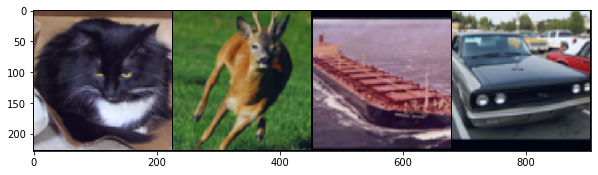

torch.return_types.max(
values=tensor([0.9421, 0.7675, 0.9540, 0.9985], grad_fn=<MaxBackward0>),
indices=tensor([5, 4, 8, 2]))
['dog' 'deer' 'ship' 'car']


In [35]:
images, labels = iter(test_loader).next()
print(class_names[labels.numpy()])
show(torchvision.utils.make_grid(images, normalize=True))
print(torch.max(model(images), axis=1))
print(class_names[torch.max(model(images), axis=1).indices]) #  угаданные сетью лейблы классов

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    airplane       0.00      0.00      0.00         0
        bird       0.00      0.00      0.00         0
         car       1.00      1.00      1.00         1
         cat       0.00      0.00      0.00         1
        deer       0.00      0.00      0.00         1
         dog       0.00      0.00      0.00         0
       horse       0.00      0.00      0.00         0
      monkey       0.00      0.00      0.00         0
        ship       1.00      1.00      1.00         1
       truck       0.00      0.00      0.00         0

   micro avg       0.50      0.50      0.50         4
   macro avg       0.20      0.20      0.20         4
weighted avg       0.50      0.50      0.50         4

[[0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 0 0 0]
 [0 0 0 0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 1 0]
 [0 0 0 0 0 0 0 0 0 0]]


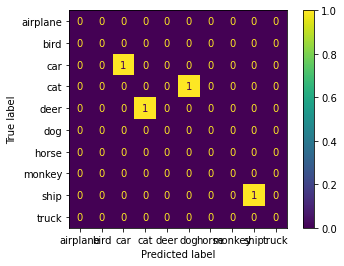

In [36]:
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report 
from sklearn.metrics import ConfusionMatrixDisplay 
 
data_true = class_names[labels.numpy()] 
data_test = class_names[torch.max(model(images), axis = 1).indices] 
print(classification_report(data_true, data_test, labels=class_names)) 
 
cm = confusion_matrix(data_true, data_test, labels=class_names) # confusion_matrix 
print(cm) 
cmd = ConfusionMatrixDisplay(cm, display_labels=class_names) 
_ = cmd.plot()